In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import OPTICS, cluster_optics_dbscan

# Load Data

In [3]:
df_train = pd.read_csv('../data/processed/train.csv')
df_train.shape

(6146, 7)

In [4]:
df_test = pd.read_csv('../data/processed/test.csv')
df_test.shape

(1537, 7)

In [5]:
# define training feature matrix 
X_train = df_train.drop(columns=['cik']) # cik is a company identifier 
X_train.shape

(6146, 6)

In [6]:
# define the testing feature matrix 
X_test = df_test.drop(columns=['cik']) # cik is a company identifier 
X_test.shape 

(1537, 6)

# Modeling 

## Cross-Validated Hyperparameter Tuning

In [8]:
def scorer(estimator, X): 
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

In [9]:
optics = OPTICS(cluster_method='dbscan')

In [10]:
param_grid = {
    'min_samples': [0.001, 0.01, 0.1],
    'eps': [0.5, 1.5, 2.5, 3.5]
}

In [11]:
grid_search = GridSearchCV(
    optics,
    param_grid,
    scoring=scorer,
    n_jobs=2
)

In [12]:
grid_search.fit(X_train.values)

C:\Users\aabel\Envs\anomalous-companies\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [-0.37844548 -0.01109913         nan  0.34946889  0.6028255   0.50728342
  0.64815962  0.70847991  0.66408424  0.72985091  0.76747349  0.73958495]
  warnings.warn(


GridSearchCV(estimator=OPTICS(cluster_method='dbscan'), n_jobs=2,
             param_grid={'eps': [0.5, 1.5, 2.5, 3.5],
                         'min_samples': [0.001, 0.01, 0.1]},
             scoring=<function scorer at 0x000002966D0C1D80>)

In [13]:
cv_results = pd.DataFrame(grid_search.cv_results_['params'])
cv_results['silhouette score'] = grid_search.cv_results_['mean_test_score']

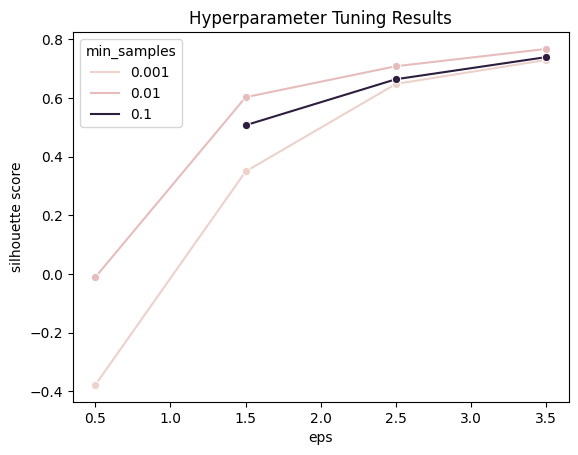

In [14]:
sns.lineplot(
    data=cv_results,
    x='eps',
    y='silhouette score',
    hue='min_samples',
    marker='o'
)
plt.title('Hyperparameter Tuning Results')
plt.show()

In [15]:
grid_search.best_params_

{'eps': 3.5, 'min_samples': 0.01}

In [16]:
grid_search.best_score_

0.7674734878638835

Epsilon of 3.5 and minimum samples of 1% yielded the highest cross-validated silhouette score. 

In [17]:
# retrain the best model on the entire training set 
model = OPTICS(min_samples=0.01, eps=3.5, cluster_method='dbscan')
model.fit(X_train)

OPTICS(cluster_method='dbscan', eps=3.5, min_samples=0.01)

In [18]:
pd.Series(model.labels_).value_counts(normalize=True)

 0    0.990238
-1    0.009762
dtype: float64

This model classifies 99% of companies in the training data as belonging to a single cluster, and the remaining 1% as anomalies. Let's view its reachability plot. 

In [21]:
def reachability_plot(optics, eps=np.inf, **kwargs):
    x = np.arange(len(optics.labels_))
    reachability = optics.reachability_
    labels = cluster_optics_dbscan(
        reachability=reachability,
        core_distances=optics.core_distances_,
        ordering=optics.ordering_,
        eps=eps
    )
    fig, ax = plt.subplots(**kwargs)
    ax.scatter(x, reachability[optics.ordering_], c=labels[optics.ordering_], alpha=0.1)
    ax.plot(np.full_like(x, eps, dtype=float), "k-", alpha=0.5)
    ax.set_title('Reachability Plot')
    ax.set_ylabel('Reachability (epsilon distance)')
    return fig

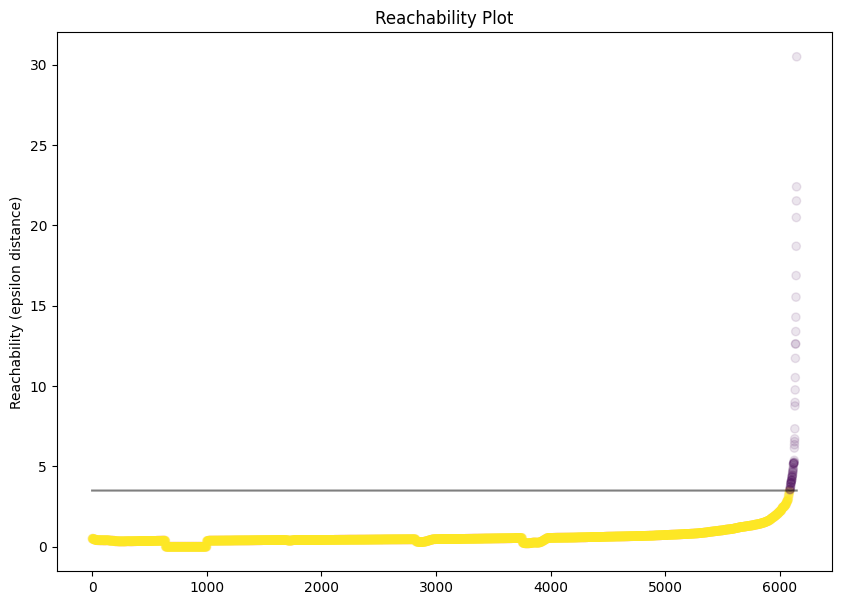

In [22]:
reachability_plot(model, eps=3.5, figsize=(10, 7))
plt.show()

# Testing 

Now let's see how the model performs on the test set. 

In [23]:
# fit the model to the test set 
test_labels = model.fit_predict(X_test.values)

In [24]:
pd.Series(test_labels).value_counts(normalize=True)

 0    0.991542
-1    0.008458
dtype: float64

The model classifies 99.2% of the companies in the test data as belonging to a single cluster, and the remaining 0.8% as anomalous. This distribution is similar to that of the training set. 

In [25]:
# check its silhouette score
silhouette_score(X_test, test_labels)

0.704840900124792

The model's silhouette score on the test set is similar to its cross-validated score.

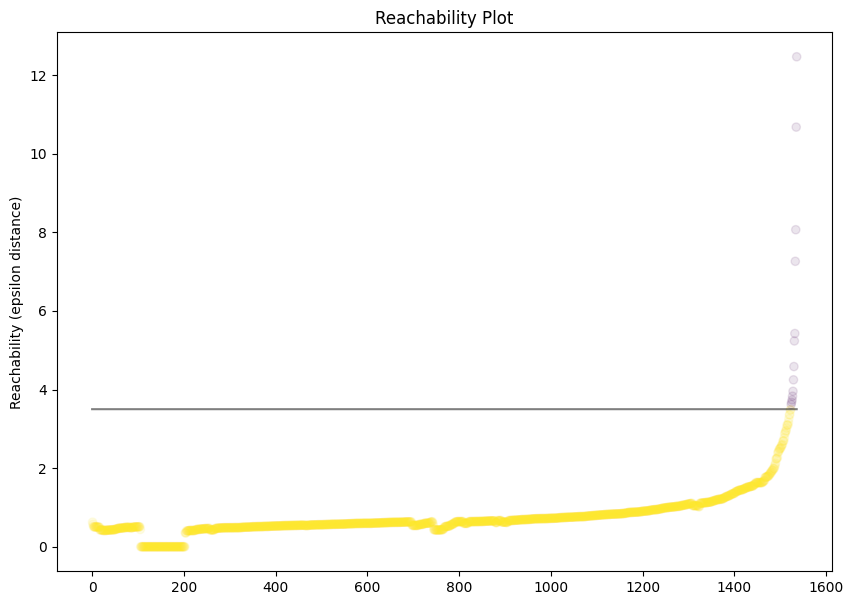

In [26]:
# inspect its reachability plot 
reachability_plot(model, eps=3.5, figsize=(10, 7))
plt.show()

# Final Model

Now let's train the final model on the entire dataset. 

In [27]:
df = pd.concat([df_train, df_test])
X = df.drop(columns=['cik'])
X.shape

(7683, 6)

In [28]:
model = OPTICS(min_samples=0.01, eps=3.5, cluster_method='dbscan')
labels = model.fit_predict(X)

In [29]:
pd.Series(labels).value_counts(normalize=True)

 0    0.989978
-1    0.010022
dtype: float64

In [31]:
df['label'] = pd.Series(labels).replace({0: 'normal', -1: 'anomalous'})
df['anomaly_score'] = model.reachability_

In [32]:
silhouette_score(X, labels)

0.7715684147510695

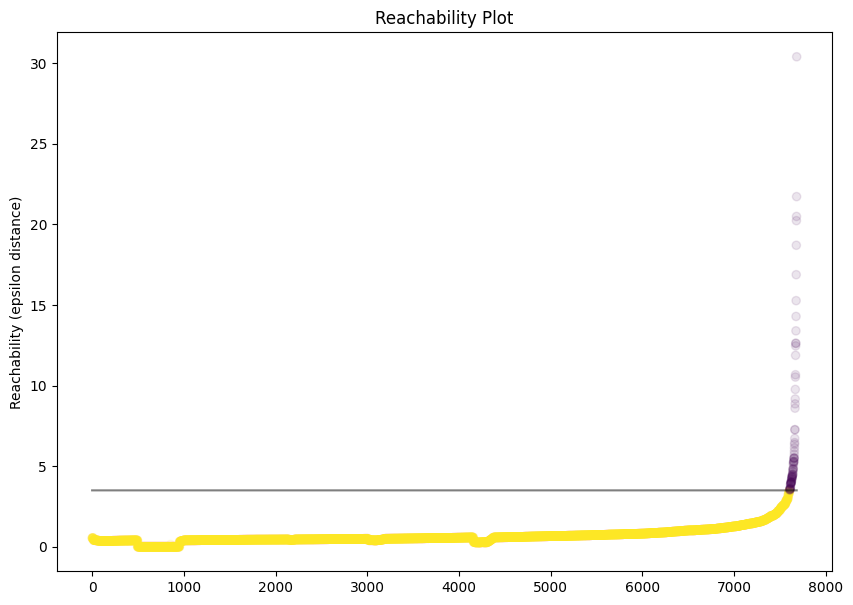

In [33]:
reachability_plot(model, eps=3.5, figsize=(10, 7))
plt.show()

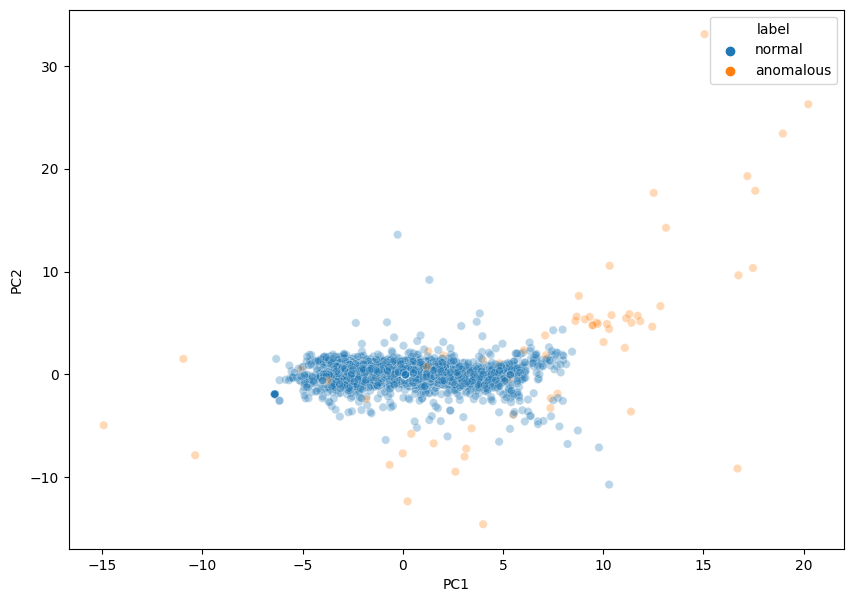

In [35]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(
    data=df,
    x='PC1',
    y='PC2',
    hue='label',
    alpha=0.3,
    ax=ax
)
plt.show()

We can sort the anomalies by their reachability scores to generate a prioritized list for manual investigation. 

In [36]:
anomalies = df.query("label == 'anomalous'").sort_values('anomaly_score', ascending=False)

Let's take a closer look at the most anomalous company. 

CIK: 310522


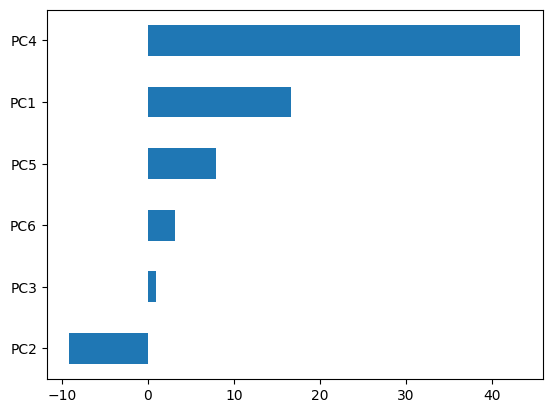

In [37]:
cik = anomalies.iloc[0]['cik']
print('CIK: {0}'.format(cik))
anomalies.iloc[0][['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']].sort_values().plot(kind='barh')
plt.show()

We can see that it is most strongly an outlier within the fourth principal component, which we interpreted as risk of insolvency. Let's take a look at its raw data it reported to the SEC.

In [38]:
df_train_interim = pd.read_csv('../data/interim/train.csv')
df_test_interim = pd.read_csv('../data/interim/test.csv')
df_interim = pd.concat([df_train_interim, df_test_interim])
df_interim.set_index('cik', inplace=True)
df_interim.query("cik == @cik").T

cik,310522
AssetsCurrent_USD,NaN
Assets_USD,3.985749e+12
CashAndCashEquivalentsAtCarryingValue_USD,3.833700e+10
CommonStockSharesAuthorized_shares,NaN
CommonStockSharesIssued_shares,1.308763e+09
CommonStockValue_USD,6.870000e+08
LiabilitiesAndStockholdersEquity_USD,3.985749e+12
LiabilitiesCurrent_USD,NaN
Liabilities_USD,3.960490e+12
RetainedEarningsAccumulatedDeficit_USD,-1.081100e+11


We can see that this company (Fannie Mae) reported an accumulated deficit of $108B.